## Distance Matrix Calculation
### Objetive: Given a Shapefile with Form and Subsections, generate a Distance Matrix 

In [1]:
# list of imports
import osmnx as ox
import geopandas as gpd
import networkx as nx
import pandas as pd
from scipy.spatial.distance import squareform, pdist
from multiprocessing import Pool
from functools import partial
import numpy as np
from shapely.geometry import Point

### Load Necessary Data


In [2]:
# Load Portugal Polygons 
polygons = gpd.read_file('./data/BGRI_2011/CONTINENTE/BGRI11_CONT.shp', dtype={'BGRI11': str})

In [3]:
# Load School Data
schools = gpd.read_file('../optimization/data_gettin/escolasourem/gdf_escolas_Ourem2019_capacidades.shp')
# Change projection to calculate distances
schools = schools.to_crs({'init': 'epsg:4326'})

### Method Declaration

In [4]:
def select_shape(column, value, polygons):
    # Load BGRI-2011 Data
    polygons = polygons[polygons[column]==value]
    shape_df = polygons.dissolve(by=column, as_index=False)
    return shape_df

In [5]:
def get_network(shape_dataFrame):
    latlng_geom, _ = ox.project_geometry(shape_dataFrame.geometry[0], crs={'init':'epsg:3763'}, to_latlong=True)
    network = ox.graph_from_polygon(latlng_geom, network_type='all_private')
    return network

In [6]:
def calculate_distance(point1, point2):
    """  
    Base function that actually solves the problem.
    Calculate the real distance between two points using the nearest node on global network.
    Parameters
    ----------
    point1 : Point
        geometry
    point2 : Point
        geometry

    Returns
    ----------
    distance : float
    
    """

    node1 = ox.utils.get_nearest_node(myNetwork, (point1.y, point1.x))
    node2 = ox.utils.get_nearest_node(myNetwork, (point2.y, point2.x))
    try:
        distance = nx.shortest_path_length(myNetwork, node1, node2, weight='length')
    except Exception as ex:
        print('Node {} not reachable from {}'.format(point1, point2))
        print(ex)
        distance = float('NaN')
    return distance

In [7]:
def parallelize_on_rows(data, func, num_of_processes=7):
    """  
    Starts the paralel process. Calls parallelize passing partial(run_calculation) as parameter. 
    Sends to a poll a dataframe to be splited and a base function to be aplied on that dataframe.
    
    Parameters
    ----------
    data : DataFrame
        a dataset in longform to be split.
    func : function
        a function to be applied on each part of data
    num_of_processes : Int
        default is 7
   

    Returns
    ----------
    Void
    
    """
    return parallelize(data, partial(run_calculation, func), num_of_processes)

def parallelize_on_rows_with_pois(data, func, num_of_processes=7):
    return parallelize(data, partial(run_calculation_to_pois, func), num_of_processes)

def parallelize(data, func, num_of_processes=7):
    """  
    Second step on paralel process. 
    Split a given dataset and aplies a given (partial) function to be processed.
    Parameters
    ----------
    data : DataFrame
        a dataset in longform to be split.
    func : Partial function
        a partial function to be applied on each part of data
    num_of_processes : Int
        default is 7
   

    Returns
    ----------
    data : DataFrame
        A concatened Dataframe with the real_distances from each splited dataset.
    
    """

    pool = Pool(num_of_processes)
    
    # This will concat the operation with the iterable itens from data_split
    listOfBgri = list(data[['origin', 'destination']].itertuples(index=True, name=None))
    df_points_origin_destination = np.array_split(listOfBgri, num_of_processes)

    # Call base function - run_calculation with calculate_distance on each part of the dataset
    data = pd.concat(pool.map(func, df_points_origin_destination))
    pool.close()
    pool.join()
    return data

def run_calculation(func, points):
    """  
    Uses the base function (calculate distance) 
    to calculate the distance between all the subsections from 
    eachother. 
    Parameters
    ----------
    data : DataFrame
        a dataset in longform to be split.
    func : Partial function
        a partial function to be applied on each part of data   

    Returns
    ----------
    data : DataFrame
        A concatened Dataframe with the different results from the method applied to each part.
    
    """
    index = []
    values = []
 
    for e in points:
        index.append(int(e[0]))
        values.append(calculate_distance(bgri.loc[(e[1])].geometry, bgri.loc[e[2]].geometry))
    partialDistances = pd.Series(values, index=index) 
    return partialDistances

def run_calculation_to_pois(func, points):
    """  
    Uses the base function (calculate distance) 
    to calculate the distance between subsections and the
    given pois. 
    Parameters
    ----------
    data : DataFrame
        a dataset in longform to be split.
    func : Partial function
        a partial function to be applied on each part of data
    num_of_processes : Int
        default is 7
   

    Returns
    ----------
    data : DataFrame
        A concatened Dataframe with the different results from the method applied to each part.
    
    """
    index = []
    values = []
 
    for e in points:
        index.append(int(e[0]))
        values.append(calculate_distance(schools.iloc[int(e[1])].geometry, bgri.loc[e[2]].geometry))
    partialDistances = pd.Series(values, index=index) 
    return partialDistances


In [8]:
def create_long_form_df(pairwise):
    long_form = pairwise.unstack()
    long_form.index.rename(['origin', 'destination'], inplace=True)
    long_form = long_form.to_frame('real_distance').reset_index()
    return long_form

In [22]:
class DistanceMatrix:
    # client
    def create_distance_matrix(self, bgri_df, sig_gdf=gpd.GeoDataFrame, num_of_processes=7):
        distance_matrix = self._verify_poi_data(sig_gdf)
        return distance_matrix(bgri_df, sig_gdf)
    
    # creator
    def _verify_poi_data(self, sig_gdf):
        if sig_gdf.empty:
            return self._simetric_distance_matrix
        elif isinstance(sig_gdf, gpd.GeoDataFrame): 
            return self._origins_to_poi_distance_matrix
        else:
            raise ValueError(sig_gdf)
    
    # Concrete Implementations
    def _simetric_distance_matrix(self, bgri_df, sig_gdf=None, num_of_processes=7):
        pairwise = pd.DataFrame(columns = bgri_df.index, index = bgri_df.index)
        long_form = create_long_form_df(pairwise)
        long_form['real_distance'] = parallelize_on_rows(long_form, calculate_distance, num_of_processes)
        return long_form

    def _origins_to_poi_distance_matrix(self, bgri_df, sig_gdf, num_of_processes=7):
        pairwise = pd.DataFrame(columns = sig_gdf.index, index = bgri_df.index)
        long_form = create_long_form_df(pairwise)
        long_form['real_distance'] = parallelize_on_rows_with_pois(long_form, calculate_distance, num_of_processes)
        return long_form

### List of Globals

In [12]:
# Select DTMN11 Code to the desired Municipality
dtmn11 = '1421'

# BGRI for the selected Place
bgri = polygons[polygons['DTMN11']==dtmn11].to_crs({'init': 'epsg:4326'})
bgri['geometry'] = bgri.centroid
bgri.index = bgri.BGRI11

# Create the shape and get the network from OSM
shape_df = select_shape('DTMN11', dtmn11, polygons)
myNetwork = get_network(shape_df)
# Change shape CRS to be compatible with polygons (optional, only required for plotting)
shape_df = shape_df.to_crs({'init': 'epsg:4326'})
# shape_df.plot()

### Main Usage

In [23]:
# Create Object
myResult = DistanceMatrix()

In [29]:
# Create a Simple Distance Matrix with all subsections
simple_distance_matrix = myResult.create_distance_matrix(bgri.head(20), num_of_processes=7)

In [26]:
# Create a Distance Matrix from POI's to subsections
pois_to_subsections_matrix = myResult.create_distance_matrix(bgri.head(3), schools.head(4))

In [14]:
# Save Result to CSV
simple_distance_matrix.to_csv('./data/distancematrix-'+dtmn11+'.csv')
pois_to_subsections_matrix.to_csv('./data/distancematrix_pois-'+dtmn11+'.csv')

### Utilities

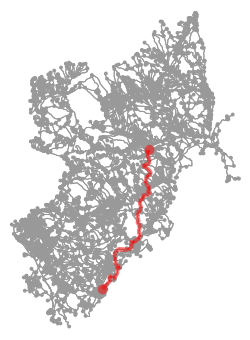

(<Figure size 406.759x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9ae1a74ba8>)

In [15]:
# Get two Points from BGRI and show the shortest path between then

node1 = ox.utils.get_nearest_node(myNetwork, (bgri.iloc[2].geometry.y, bgri.iloc[2].geometry.x), method='euclidean')

node2 = ox.utils.get_nearest_node(myNetwork, (bgri.iloc[1000].geometry.y, bgri.iloc[1000].geometry.x), method='euclidean')

route = nx.shortest_path(myNetwork, node1, node2)
ox.plot_graph_route(myNetwork, route)

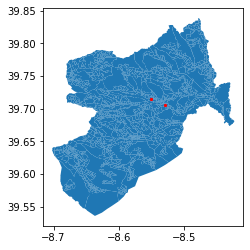

In [16]:
# How to plot points using the polygons as base

points = bgri.loc[['14210400421', '14210400209']]
base = polygons[polygons['DTMN11']=='1421'].to_crs({'init': 'epsg:4326'}).plot()
points.plot(ax=base, marker='o', color='red', markersize=5);

In [17]:
# Calculate the Distance Matrix for the BGRI and The Given POI data - Schools, and merge with GETIN Capacity data
result = myResult.create_distance_matrix(bgri.head(3), schools.head(4))

result = pd.merge(result, 
                  schools[['Nome_Escol', 'FID_x','Capacidade', 'Capacida_1', 'Capacida_2','Capacida_3','Capacida_4','geometry']],
                  how='left', left_on=[result.origin], right_on=[schools.index])

result.drop(columns='key_0', inplace=True)

result.to_csv('./data/distance_matrix_schools'+dtmn11+'.csv')